<a href="https://colab.research.google.com/github/afccacador13/OpenHPI_DSBootcamp/blob/main/Euribor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, kurtosis, kstest
from statsmodels.tsa.stattools import adfuller

In [ ]:
er_data = pd.read_excel('ECB_EURIBOR_RATES.xls')

In [ ]:
er_data

,DATE,EURIBOR_3M,EURIBOR_6M,EURIBOR_1Y
0,1994-01-31,6.910000,6.670000,6.340000
1,1994-02-28,6.860000,6.680000,6.420000
2,1994-03-31,6.750000,6.650000,6.550000
3,1994-04-30,6.570000,6.510000,6.460000
4,1994-05-31,6.240000,6.210000,6.250000
...,...,...,...,...
369,2024-10-31,3.166609,3.001609,2.691304
370,2024-11-30,3.006762,2.787524,2.505571
371,2024-12-31,2.816091,2.630318,2.438318
372,2025-01-31,2.703130,2.612130,2.522130


In [ ]:
# --- Function to select variables and perform ADF ---
def adf_perform(variable_list, data):

  results = []
  for var in variable_list:

      # Sort by time if needed (optional, but recommended)
      if 'date' in data.columns:
          data = data.sort_values('date')

      series = data[var].dropna()

      for lag in [0, 1, 2, 3]:
          try:
              adf_result = adfuller(series, maxlag=lag, regression='c', autolag=None)
              results.append({
                  'Variable': var,
                  'Lag': lag,
                  'ADF Statistic': adf_result[0],
                  'p-value': adf_result[1],
                  'Used Lag': adf_result[2],
                  'N Observations': adf_result[3],
                  **{f"CV {k}": v for k, v in adf_result[4].items()}
              })
          except Exception as e:
              print(f"ADF test failed for {var} (lag {lag}): {e}")

  return results


In [ ]:

variable_list = ['EURIBOR_3M','EURIBOR_6M','EURIBOR_1Y']

results= adf_perform(variable_list, er_data)

# --- Save and display results ---
results_adf = pd.DataFrame(results)
results_adf

,Variable,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,EURIBOR_3M,0,-2.324461,0.164200,0,373,-3.448004,-2.869320,-2.570915
1,EURIBOR_3M,1,-2.181491,0.213032,1,372,-3.448052,-2.869341,-2.570926
2,EURIBOR_3M,2,-2.211442,0.202119,2,371,-3.448100,-2.869362,-2.570937
3,EURIBOR_3M,3,-2.307920,0.169426,3,370,-3.448148,-2.869383,-2.570948
4,EURIBOR_6M,0,-2.133579,0.231228,0,373,-3.448004,-2.869320,-2.570915
5,EURIBOR_6M,1,-2.153120,0.223698,1,372,-3.448052,-2.869341,-2.570926
6,EURIBOR_6M,2,-2.250666,0.188373,2,371,-3.448100,-2.869362,-2.570937
7,EURIBOR_6M,3,-2.385598,0.145843,3,370,-3.448148,-2.869383,-2.570948
8,EURIBOR_1Y,0,-1.833711,0.363858,0,373,-3.448004,-2.869320,-2.570915
9,EURIBOR_1Y,1,-2.091151,0.248088,1,372,-3.448052,-2.869341,-2.570926


In [ ]:
# reshape data to make transformations easier (also drop EURIBOR_1M)

#er_data_transform = er_data.drop('EURIBOR_1M', axis=1)
er_data_transform = pd.melt(er_data, id_vars=['DATE'], var_name='Variable',value_name='Value')
er_data_transform['stationary'] = 'No'

In [ ]:
er_data_transform

,DATE,Variable,Value,stationary
0,1994-01-31,EURIBOR_3M,6.910000,No
1,1994-02-28,EURIBOR_3M,6.860000,No
2,1994-03-31,EURIBOR_3M,6.750000,No
3,1994-04-30,EURIBOR_3M,6.570000,No
4,1994-05-31,EURIBOR_3M,6.240000,No
...,...,...,...,...
1117,2024-10-31,EURIBOR_1Y,2.691304,No
1118,2024-11-30,EURIBOR_1Y,2.505571,No
1119,2024-12-31,EURIBOR_1Y,2.438318,No
1120,2025-01-31,EURIBOR_1Y,2.522130,No


In [ ]:
# --- Apply possible transformations to data to improve stationarity ---

# 1. Log Transformation
er_data_transform['value_log'] = np.log(er_data_transform['Value'])

# 2. Root Transformation
er_data_transform['value_sqrt'] = np.sqrt(er_data_transform['Value'])

# 3. Cube Transformation
er_data_transform['value_cbrt'] = np.cbrt(er_data_transform['Value'])

# 4. Proportional Transformation
er_data_transform['proportional_change'] = er_data_transform['Value'].pct_change()

er_data_transform.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,DATE,Variable,Value,stationary,value_log,value_sqrt,value_cbrt,proportional_change
0,1994-01-31,EURIBOR_3M,6.91,No,1.932970,2.628688,1.904698,NaN
1,1994-02-28,EURIBOR_3M,6.86,No,1.925707,2.619160,1.900092,-0.007236
2,1994-03-31,EURIBOR_3M,6.75,No,1.909543,2.598076,1.889882,-0.016035
3,1994-04-30,EURIBOR_3M,6.57,No,1.882514,2.563201,1.872931,-0.026667
4,1994-05-31,EURIBOR_3M,6.24,No,1.830980,2.497999,1.841033,-0.050228


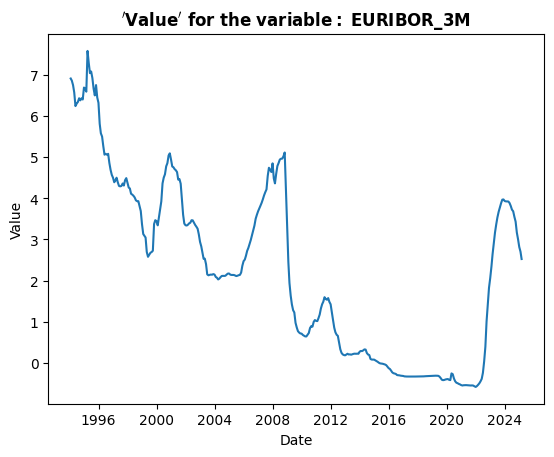

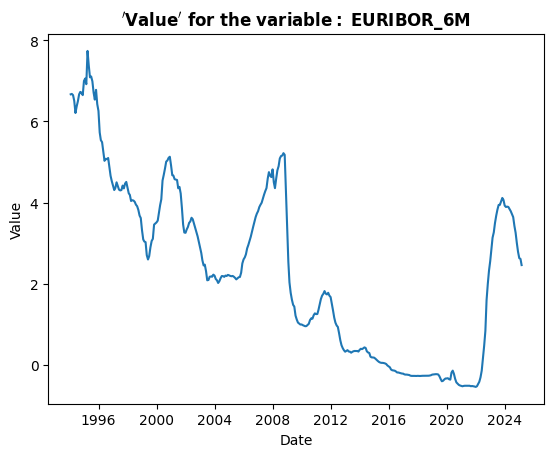

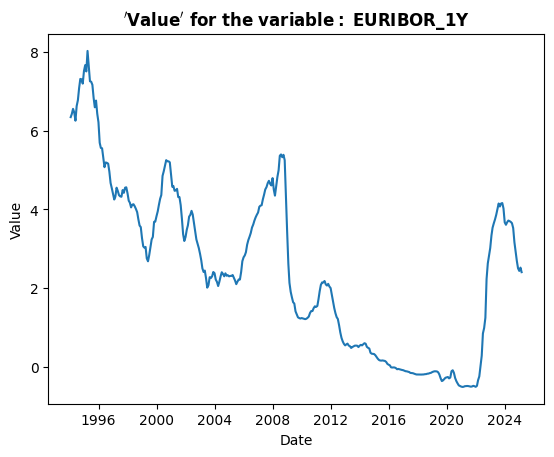

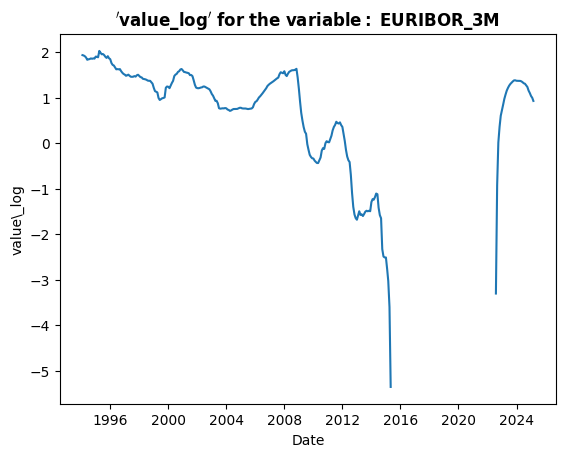

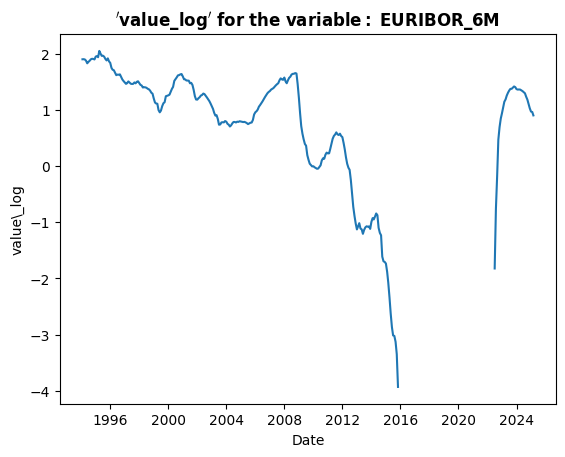

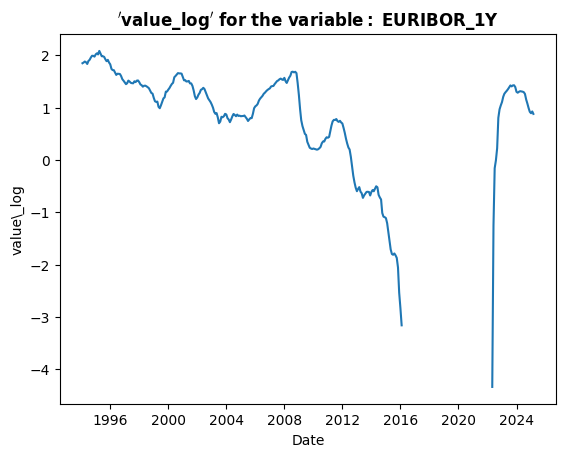

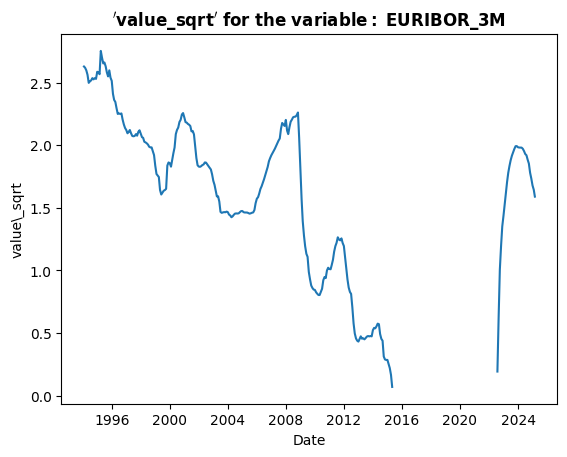

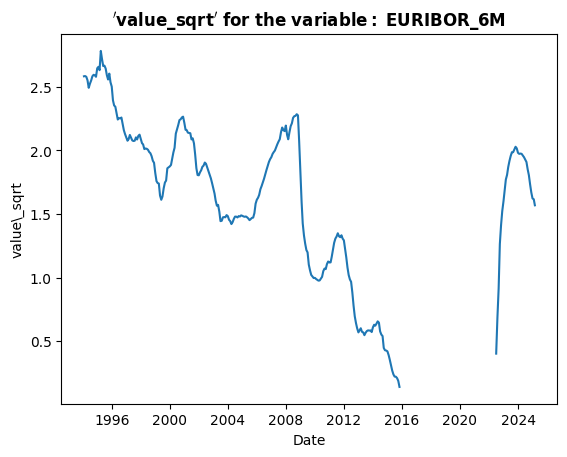

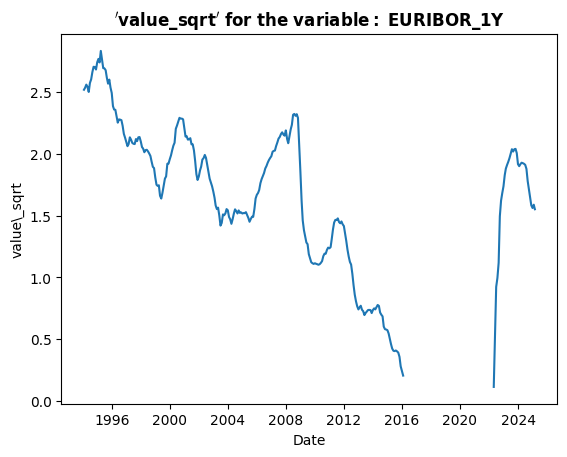

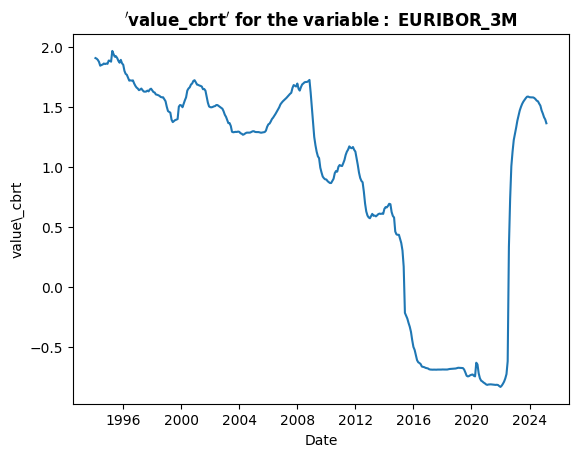

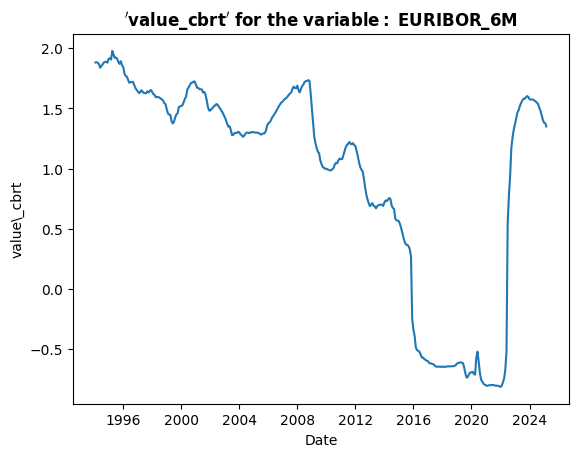

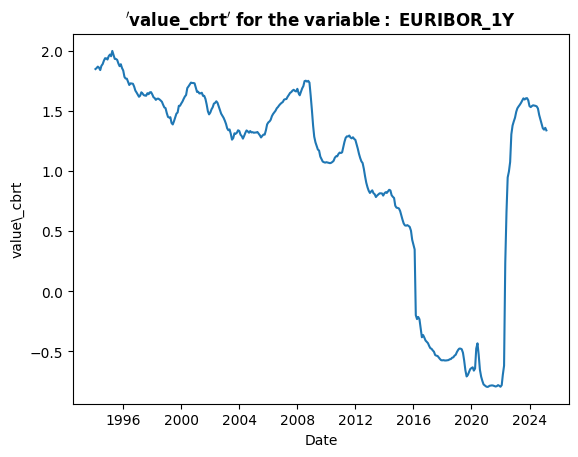

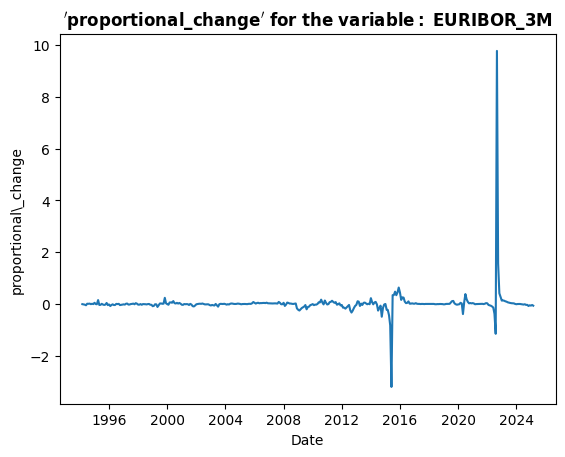

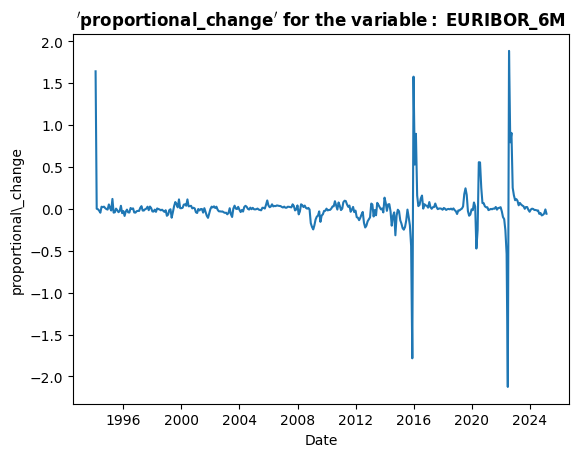

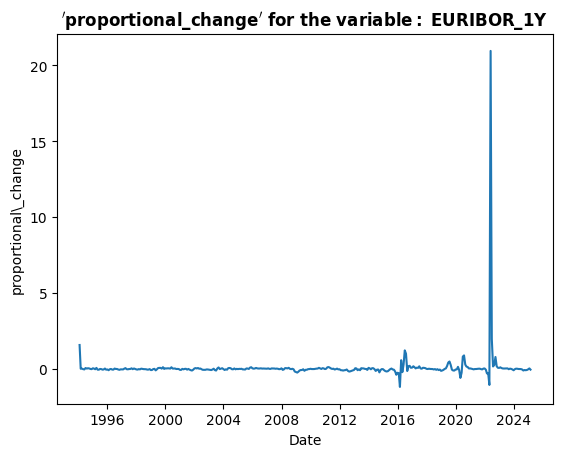

In [ ]:
# --plot to check --
col_list = ['Value', 'value_log', 'value_sqrt', 'value_cbrt', 'proportional_change']

for col in col_list:

  for var in variable_list:
    var_legend = var.replace('_',r'\_')
    col_legend = col.replace('_',r'\_')

    er_data_transform_var = er_data_transform[er_data_transform['Variable']==var]
    plt.plot(er_data_transform_var['DATE'], er_data_transform_var[col], label=var)
    plt.xlabel('Date')
    plt.ylabel(f'{col_legend}')
    plt.title(fr"$\mathbf{{ '{col_legend}'\ for\ the\ variable:\ {var_legend}}}$")
    plt.show()

In [ ]:
er_data_transform['transformation'] = 'proportional_change'

In [ ]:
## --- Re run ADF with transformations applied --

def adf_perform_short(data, var_list, var_column):
  results = []

  for var in var_list:
    series = data[var_column].dropna()

    for lag in [0, 1, 2, 3]:
        try:
            adf_result = adfuller(series, maxlag=lag, regression='c', autolag=None)
            results.append({
                'Variable': var,
                'Lag': lag,
                'ADF Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Used Lag': adf_result[2],
                'N Observations': adf_result[3],
                **{f"CV {k}": v for k, v in adf_result[4].items()}
            })
        except Exception as e:
            print(f"ADF test failed for {var} (lag {lag}): {e}")
  return results


var_list=['EURIBOR_3M','EURIBOR_6M','EURIBOR_1Y']

results_log = adf_perform_short(er_data_transform, var_list, 'value_log')
results_log_adf = pd.DataFrame(results_log)

results_sqrt = adf_perform_short(er_data_transform, var_list, 'value_sqrt')
results_sqrt_adf = pd.DataFrame(results_sqrt)

results_cbrt = adf_perform_short(er_data_transform, var_list, 'value_cbrt')
results_cbrt_adf = pd.DataFrame(results_cbrt)

results_porp = adf_perform_short(er_data_transform, var_list, 'proportional_change')
results_porp_adf = pd.DataFrame(results_porp)


In [ ]:
# 1. Log Transformation
results_log_adf

,Variable,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,EURIBOR_3M,0,-3.069402,0.028902,0,882,-3.437786,-2.864822,-2.568518
1,EURIBOR_3M,1,-4.056525,0.001142,1,881,-3.437794,-2.864826,-2.568520
2,EURIBOR_3M,2,-3.846721,0.002464,2,880,-3.437803,-2.864830,-2.568522
3,EURIBOR_3M,3,-4.121307,0.000893,3,879,-3.437811,-2.864834,-2.568524
4,EURIBOR_6M,0,-3.069402,0.028902,0,882,-3.437786,-2.864822,-2.568518
5,EURIBOR_6M,1,-4.056525,0.001142,1,881,-3.437794,-2.864826,-2.568520
6,EURIBOR_6M,2,-3.846721,0.002464,2,880,-3.437803,-2.864830,-2.568522
7,EURIBOR_6M,3,-4.121307,0.000893,3,879,-3.437811,-2.864834,-2.568524
8,EURIBOR_1Y,0,-3.069402,0.028902,0,882,-3.437786,-2.864822,-2.568518
9,EURIBOR_1Y,1,-4.056525,0.001142,1,881,-3.437794,-2.864826,-2.568520


In [ ]:
# 2. Root Transformation
results_sqrt_adf

,Variable,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,EURIBOR_3M,0,-2.196278,0.207599,0,882,-3.437786,-2.864822,-2.568518
1,EURIBOR_3M,1,-3.041034,0.031236,1,881,-3.437794,-2.864826,-2.568520
2,EURIBOR_3M,2,-3.412173,0.010551,2,880,-3.437803,-2.864830,-2.568522
3,EURIBOR_3M,3,-3.709489,0.003982,3,879,-3.437811,-2.864834,-2.568524
4,EURIBOR_6M,0,-2.196278,0.207599,0,882,-3.437786,-2.864822,-2.568518
5,EURIBOR_6M,1,-3.041034,0.031236,1,881,-3.437794,-2.864826,-2.568520
6,EURIBOR_6M,2,-3.412173,0.010551,2,880,-3.437803,-2.864830,-2.568522
7,EURIBOR_6M,3,-3.709489,0.003982,3,879,-3.437811,-2.864834,-2.568524
8,EURIBOR_1Y,0,-2.196278,0.207599,0,882,-3.437786,-2.864822,-2.568518
9,EURIBOR_1Y,1,-3.041034,0.031236,1,881,-3.437794,-2.864826,-2.568520


In [ ]:
results_cbrt_adf

,Variable,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,EURIBOR_3M,0,-1.523718,0.521747,0,1121,-3.436197,-2.864122,-2.568145
1,EURIBOR_3M,1,-2.257754,0.185955,1,1120,-3.436202,-2.864124,-2.568146
2,EURIBOR_3M,2,-2.521760,0.110269,2,1119,-3.436207,-2.864126,-2.568147
3,EURIBOR_3M,3,-2.674837,0.078495,3,1118,-3.436213,-2.864129,-2.568148
4,EURIBOR_6M,0,-1.523718,0.521747,0,1121,-3.436197,-2.864122,-2.568145
5,EURIBOR_6M,1,-2.257754,0.185955,1,1120,-3.436202,-2.864124,-2.568146
6,EURIBOR_6M,2,-2.521760,0.110269,2,1119,-3.436207,-2.864126,-2.568147
7,EURIBOR_6M,3,-2.674837,0.078495,3,1118,-3.436213,-2.864129,-2.568148
8,EURIBOR_1Y,0,-1.523718,0.521747,0,1121,-3.436197,-2.864122,-2.568145
9,EURIBOR_1Y,1,-2.257754,0.185955,1,1120,-3.436202,-2.864124,-2.568146


In [ ]:
results_porp_adf

,Variable,Lag,ADF Statistic,p-value,Used Lag,N Observations,CV 1%,CV 5%,CV 10%
0,EURIBOR_3M,0,-31.604159,0.000000e+00,0,1120,-3.436202,-2.864124,-2.568146
1,EURIBOR_3M,1,-23.074800,0.000000e+00,1,1119,-3.436207,-2.864126,-2.568147
2,EURIBOR_3M,2,-19.010117,0.000000e+00,2,1118,-3.436213,-2.864129,-2.568148
3,EURIBOR_3M,3,-16.131665,4.778178e-29,3,1117,-3.436218,-2.864131,-2.568150
4,EURIBOR_6M,0,-31.604159,0.000000e+00,0,1120,-3.436202,-2.864124,-2.568146
5,EURIBOR_6M,1,-23.074800,0.000000e+00,1,1119,-3.436207,-2.864126,-2.568147
6,EURIBOR_6M,2,-19.010117,0.000000e+00,2,1118,-3.436213,-2.864129,-2.568148
7,EURIBOR_6M,3,-16.131665,4.778178e-29,3,1117,-3.436218,-2.864131,-2.568150
8,EURIBOR_1Y,0,-31.604159,0.000000e+00,0,1120,-3.436202,-2.864124,-2.568146
9,EURIBOR_1Y,1,-23.074800,0.000000e+00,1,1119,-3.436207,-2.864126,-2.568147


In [ ]:
er_data_transform.head(1)

,DATE,Variable,Value,stationary,value_log,value_sqrt,value_cbrt,proportional_change,transformation
0,1994-01-31,EURIBOR_3M,6.91,No,1.93297,2.628688,1.904698,NaN,proportional_change


EURIBOR_3M Mean: 0.018
EURIBOR_3M STD: 0.555
EURIBOR_3M Skewness: nan
EURIBOR_3M Kurtosis: nan
EURIBOR_3M Shapiro Stat: nan    p-value: nan
EURIBOR_3M KS statistic: nan     p-value: nan 



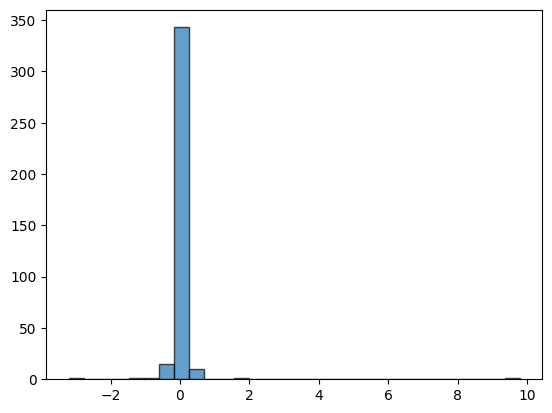

EURIBOR_6M Mean: 0.002
EURIBOR_6M STD: 0.244
EURIBOR_6M Skewness: 0.292
EURIBOR_6M Kurtosis: 41.69
EURIBOR_6M Shapiro Stat: 0.434    p-value: 0.0
EURIBOR_6M KS statistic: 0.40255370363524146     p-value: 3.0897612219589817e-55 



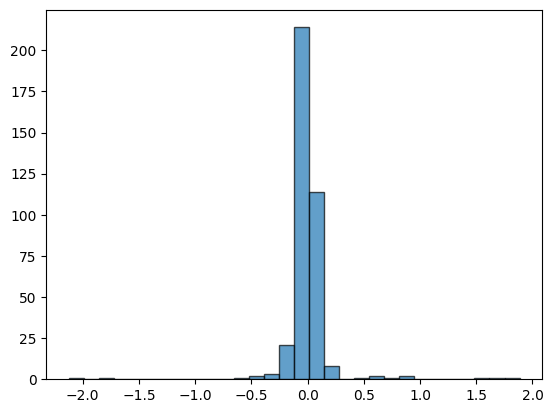

EURIBOR_1Y Mean: 0.067
EURIBOR_1Y STD: 1.104
EURIBOR_1Y Skewness: 18.218
EURIBOR_1Y Kurtosis: 341.932
EURIBOR_1Y Shapiro Stat: 0.086    p-value: 0.0
EURIBOR_1Y KS statistic: 0.39363770163488965     p-value: 9.638323923704255e-53 



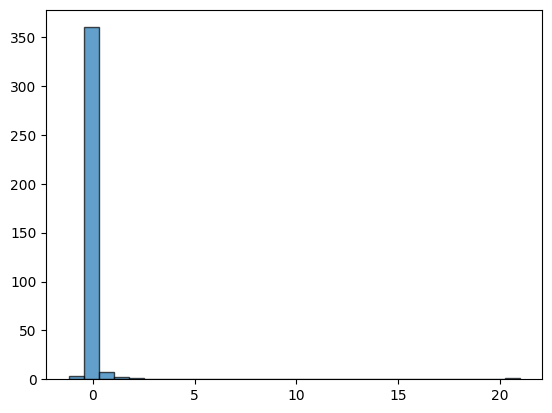

In [ ]:
# --- Check Normalization ---

transform='proportional_change'


eur_3m = er_data_transform[er_data_transform['Variable']=='EURIBOR_3M'][transform]
eur_6m = er_data_transform[er_data_transform['Variable']=='EURIBOR_6M'][transform]
eur_1y = er_data_transform[er_data_transform['Variable']=='EURIBOR_1Y'][transform]

n_bins=30

print('EURIBOR_3M Mean:', round(eur_3m.mean(),3))
print('EURIBOR_3M STD:', round(eur_3m.std(),3))
print('EURIBOR_3M Skewness:', round(skew(eur_3m),3))
print('EURIBOR_3M Kurtosis:', round(kurtosis(eur_3m),3))
print('EURIBOR_3M Shapiro Stat:',round(stats.shapiro(eur_3m)[0], 3) , '   p-value:', round(stats.shapiro(eur_3m)[1], 3))

eur_3m_statistic, eur_3m_p_value = kstest(eur_3m, 'norm')
print(f"EURIBOR_3M KS statistic: {eur_3m_statistic}    ", f"p-value: {eur_3m_p_value}", '\n')

plt.hist(eur_3m, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()



print('EURIBOR_6M Mean:', round(eur_6m.mean(),3))
print('EURIBOR_6M STD:', round(eur_6m.std(),3))
print('EURIBOR_6M Skewness:', round(skew(eur_6m),3))
print('EURIBOR_6M Kurtosis:', round(kurtosis(eur_6m),3))
print('EURIBOR_6M Shapiro Stat:',round(stats.shapiro(eur_6m)[0], 3) , '   p-value:', round(stats.shapiro(eur_6m)[1], 3))

eur_6m_statistic, eur_6m_p_value = kstest(eur_6m, 'norm')
print(f"EURIBOR_6M KS statistic: {eur_6m_statistic}    ", f"p-value: {eur_6m_p_value}", '\n')

plt.hist(eur_6m, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()


print('EURIBOR_1Y Mean:', round(eur_1y.mean(),3))
print('EURIBOR_1Y STD:', round(eur_1y.std(),3))
print('EURIBOR_1Y Skewness:', round(skew(eur_1y),3))
print('EURIBOR_1Y Kurtosis:', round(kurtosis(eur_1y),3))
print('EURIBOR_1Y Shapiro Stat:',round(stats.shapiro(eur_1y)[0], 3) , '   p-value:', round(stats.shapiro(eur_1y)[1], 3))

eur_1y_statistic, eur_1y_p_value = kstest(eur_1y, 'norm')
print(f"EURIBOR_1Y KS statistic: {eur_1y_statistic}    ", f"p-value: {eur_1y_p_value}", '\n')

plt.hist(eur_1y, bins=n_bins, edgecolor='black', alpha=0.7)
plt.show()

In [ ]:
## -- Normalization using median (as data does not appear to follow normal distribution) --

eur_3m_median = eur_3m.median()
eur_6m_median = eur_6m.median()
eur_1y_median = eur_1y.median()

eur_3m_avg = eur_3m.mean()
eur_6m_avg = eur_6m.mean()
eur_1y_avg = eur_1y.mean()


#Add label saying how normalization was made
er_data_transform['normalization'] = 'Median'


er_data_transform.loc[er_data_transform['Variable']=='EURIBOR_3M' , 'value_normalized'] = (er_data_transform['proportional_change'] - eur_3m_median)/(abs(er_data_transform['proportional_change'] - eur_3m_avg).median())
er_data_transform.loc[er_data_transform['Variable']=='EURIBOR_6M' , 'value_normalized'] = (er_data_transform['proportional_change'] - eur_6m_median)/(abs(er_data_transform['proportional_change'] - eur_6m_avg).median())
er_data_transform.loc[er_data_transform['Variable']=='EURIBOR_1Y' , 'value_normalized'] = (er_data_transform['proportional_change'] - eur_1y_median)/(abs(er_data_transform['proportional_change'] - eur_1y_avg).median())

In [ ]:
er_data_transform.head()

,DATE,Variable,Value,stationary,value_log,value_sqrt,value_cbrt,proportional_change,transformation,normalization,value_normalized
0,1994-01-31,EURIBOR_3M,6.91,No,1.932970,2.628688,1.904698,NaN,proportional_change,Median,NaN
1,1994-02-28,EURIBOR_3M,6.86,No,1.925707,2.619160,1.900092,-0.007236,proportional_change,Median,-0.198199
2,1994-03-31,EURIBOR_3M,6.75,No,1.909543,2.598076,1.889882,-0.016035,proportional_change,Median,-0.455967
3,1994-04-30,EURIBOR_3M,6.57,No,1.882514,2.563201,1.872931,-0.026667,proportional_change,Median,-0.767420
4,1994-05-31,EURIBOR_3M,6.24,No,1.830980,2.497999,1.841033,-0.050228,proportional_change,Median,-1.457654


In [ ]:
#Last treatments before saving

eur_final_data=er_data_transform.drop(columns=['value_log','value_sqrt','value_cbrt'])
eur_final_data.rename(columns={'proportional_change':'value_transformed' }, inplace=True)
eur_final_data = eur_final_data[['Variable',	'DATE',	'Value', 'stationary','transformation', 'value_transformed'	,	'normalization',	'value_normalized']]
eur_final_data

,Variable,DATE,Value,stationary,transformation,value_transformed,normalization,value_normalized
0,EURIBOR_3M,1994-01-31,6.910000,No,proportional_change,NaN,Median,NaN
1,EURIBOR_3M,1994-02-28,6.860000,No,proportional_change,-0.007236,Median,-0.198199
2,EURIBOR_3M,1994-03-31,6.750000,No,proportional_change,-0.016035,Median,-0.455967
3,EURIBOR_3M,1994-04-30,6.570000,No,proportional_change,-0.026667,Median,-0.767420
4,EURIBOR_3M,1994-05-31,6.240000,No,proportional_change,-0.050228,Median,-1.457654
...,...,...,...,...,...,...,...,...
1117,EURIBOR_1Y,2024-10-31,2.691304,No,proportional_change,-0.083358,Median,-1.118066
1118,EURIBOR_1Y,2024-11-30,2.505571,No,proportional_change,-0.069012,Median,-0.920631
1119,EURIBOR_1Y,2024-12-31,2.438318,No,proportional_change,-0.026841,Median,-0.340256
1120,EURIBOR_1Y,2025-01-31,2.522130,No,proportional_change,0.034373,Median,0.502209


In [ ]:
# Save results
eur_final_data.to_csv('stats_euribor.csv', index=False)